#### OSGA-V Implementation for Optimal Data Fusion

In [1]:
'''
OSGA-V for optimal data fusion in presence of unknown correlations
'''

import numpy as np
import math
from IPython.core.debugger import set_trace

def to_matrix_vector(matrix_array):
    '''
    Converts an array of A_i to [A_1, ..., A_N]^T
    '''
    n, m, l = matrix_array.shape
    assert (m == l)
    return np.transpose(np.concatenate(matrix_array, axis=1))

def to_matrix_array(matrix_vector):
    '''
    Converts a matrix vector to an array of matrices
    '''
    n, m = matrix_vector.shape
    assert (n > m)
    return np.asarray(np.hsplit(np.transpose(matrix_vector), n / m))
    
def pus(delta, alpha_max, kappa_p, kappa, alpha, h_bar, gamma_bar, eta_bar, w_bar, eta, h, gamma, w):
    '''
    Performs the parameter updating scheme
    '''
    R = (eta - eta_bar) / (delta * alpha * eta)
    if R < 1:
        alpha_bar = alpha * math.exp(-kappa)
    else:
        alpha_bar = min(alpha * math.exp(kappa_p * (R - 1)), alpha_max)
    alpha = alpha_bar
    if eta_bar < eta:
        h = h_bar
        gamma = gamma_bar
        eta = eta_bar
        w = w_bar
    return alpha, h, gamma, eta, w

def dagger_transform(in_mat_vec):
    '''
    Converts a matrix vector to its daggger edition (element-matrix-wise transpose)
    '''
    n, m = in_mat_vec.shape
    splitted = np.asarray(np.hsplit(np.transpose(in_mat_vec), n/m))
    for i in range(len(splitted)):
        splitted[i] = np.transpose(splitted[i])
    return to_matrix_vector(splitted)

def solve_subproblem(gamma_b, h, b_hat, Sigma_inv, V_prime_joint_neg_sqrt):
    '''
    Solves the E(gamma_b, h), U(gamma_b, h) subproblem
    All vectors are assumed to be in matrix vector format
    '''
    NM, M = h.shape # shape NM x M
    assert (NM > M and (NM % M) == 0)
    N = int(NM / M)
    assert ((NM, M) == b_hat.shape)
    assert ((M, M) == Sigma_inv.shape)
    assert ((NM, NM) == V_prime_joint_neg_sqrt.shape)
    
    h_hat = np.matmul(V_prime_joint_neg_sqrt, h)
    Omega = np.matmul(np.transpose(h_hat), b_hat)
    Omega_Sigma_inv = np.matmul(Omega, Sigma_inv)
    b_hat_array = to_matrix_array(b_hat)
    h_hat_array = to_matrix_array(h_hat)
    r_list = list()
    for i in range(N):
        r_list.append(np.matmul(Omega_Sigma_inv, b_hat_array[i]) - h_hat_array[i])
    r_array = np.asarray(r_list)
    beta1 = 1 + np.trace(Sigma_inv) / 2
    beta2 = gamma_b
    for i in range(N):
        b_i_T_sigma_inv = np.matmul(np.transpose(b_hat_array[i]), Sigma_inv)
        beta2 = beta2 + np.trace(np.matmul(r_array[i], b_i_T_sigma_inv))
        beta2 = beta2 + np.trace(np.matmul(h_hat_array[i], b_i_T_sigma_inv))
    beta3 = 0
    for i in range(N):
        beta3 = beta3 + np.trace(np.matmul(r_array[i], np.transpose(r_array[i]))) / 2
        beta3 = beta3 + np.trace(np.matmul(h_hat_array[i], np.transpose(r_array[i])))
    eta = (-beta2 + np.sqrt(beta2 * beta2 - 4 * beta1 * beta3)) / (2 * beta1)
    p_list = list()
    for i in range(N):
        p_list.append(r_array[i] / eta + np.matmul(Sigma_inv, b_hat_array[i]))
    p_mat_vec = to_matrix_vector(np.asarray(p_list))
    u_hat_mat_vec = np.matmul(V_prime_joint_neg_sqrt, p_mat_vec)
    return eta, u_hat_mat_vec

def oracle_call(x, unknown_corr_flags, V_prime):
    '''
    Given the value point x, given as a matrix vector, 
    return a subgradient, and f(x)
    V_prime has shape (N, N, M, M) having I for diagonal blocks and 
        V_prime_ij for known correlations
    '''
    xa = to_matrix_array(x)
    N, M, _ = xa.shape
    fx = 0
    sub_gradient = np.zeros((N, M, M), np.float32)
    for i in range(N):
        for j in range(N):
            if j != i and unknown_corr_flags[i, j]:
                C, Lambda_ij, D = np.linalg.svd(np.matmul(np.transpose(xa[j]), xa[i]))
                D = np.transpose(D) # convention of python linalg library
                fx = fx + np.sum(Lambda_ij)
                sub_gradient[i] = sub_gradient[i] + np.matmul(np.matmul(xa[j], C), np.transpose(D))
            else:
                sub_gradient[i] = sub_gradient[i] + np.matmul(xa[j], np.transpose(V_prime[i, j]))
                fx = fx + np.trace(np.matmul(xa[i], np.matmul(V_prime[i, j], np.transpose(xa[j]))))
        sub_gradient[i] = sub_gradient[i] * 2.0
    return sub_gradient, fx

# Usage:
#   a_i, mse, v_opt, v_ij_opt = gdof (
#    N, M, 
#    joint_covariance, 
#    unknown_index_matrix)
#
# Inputs:
#   N - the input measurement count
#   M - the input measurement dimension
#   joint_covariance - the joint covariance matrix
#       for the all the measurements. It's a 4-d
#       tensor, with the first two dimensions
#       referring to the measurements and the last
#       two dimensions referring to the measurement
#       components. For unknown cross-correlation
#       matrices, the values are not used.
#   unknown_corr_flags - a bool numpy array.
#       the element of the matrix at
#       location (i,j) is set to be one if V_ij is unknown.
#       otherwise it is set to be zero.
#
# Outputs:
# . a_i - the matrix weights, a tensor of 3d, with the first
# .       dimension index being the measurement index
# . mse - the resulting mean square error
# . v_opt - the estimate covariance
#   v_ij_opt - the maximizing cross correlation matrix at (i,j)
def OSGAV(N, M, joint_covariance, unknown_corr_flags, max_iteration=1000):
    assert (N, N, M, M) == joint_covariance.shape
    assert (N, N) == unknown_index_matrix.shape
    
    mu = 0
    alpha_max = 0.5
    delta = 0.5
    kappa_p = 0.4
    kappa = 0.8
    
    V = joint_covariance
    B = np.zeros((N, M, M), dtype=np.float32)
    Lambda_inv_sqrt = np.zeros((N,M), dtype=np.float32)
    U = np.zeros((N, M, M), dtype=np.float32)
    for i in range(N):
        Lambda_inv_sqrt[i], U[i] = np.linalg.eigh(joint_covariance[i, i])
        Lambda_inv_sqrt[i] = np.reciprocal(np.sqrt(Lambda_inv_sqrt[i]))
        B[i] = np.matmul(np.diag(Lambda_inv_sqrt[i]), np.transpose(U[i]))
    
    V_prime = np.zeros((N, N, M, M), dtype=np.float32)
    for i in range(N):
        for j in range(N):
            if i == j:
                V_prime[i, j] = np.identity(M, dtype=np.float32)
            elif (not unknown_corr_flags[i, j]):
                V_prime[i, j] = np.matmul(np.diag(Lambda_inv_sqrt[i]), np.transpose(U[i]))
                V_prime[i, j] = np.matmul(V_prime[i, j], V[i, j])
                V_prime[i, j] = np.matmul(V_prime[i, j], U[j])
                V_prime[i, j] = np.matmul(V_prime[i, j], np.diag(Lambda_inv_sqrt[j]))
    
    V_joint_list = list()
    for i in range(N):
        V_joint_list.append(np.concatenate(V_prime[i], axis=1))
    V_prime_joint = np.concatenate(np.asarray(V_joint_list), axis=0)
    lambda_v, Ut = np.linalg.eigh(V_prime_joint)
    V_prime_joint_neg_sqrt = np.matmul(np.matmul(Ut, np.diag(1.0 / np.sqrt(lambda_v))), np.transpose(Ut))
    B_mat_vec = to_matrix_vector(B)
    B_hat_mat_vec = np.matmul(V_prime_joint_neg_sqrt, dagger_transform(B_mat_vec))
    
    Sigma = np.matmul(np.transpose(B_hat_mat_vec), B_hat_mat_vec)
    Sigma_inv = np.linalg.inv(Sigma)
    
    x_opt = np.array([[ 0., 1.],[0, 0], [ 1.41421354, 0.], [0, 0],[0, 0],[0, 0]], dtype=np.float32)

    # initial A_prime values
    A_prime = np.zeros((N, M, M), dtype=np.float32)
    for i in range(N):
        A_prime[i] = np.matmul(U[i], np.diag(np.reciprocal(Lambda_inv_sqrt[i]))) / N
    x_b = to_matrix_vector(A_prime)
    sub_gradient, fx_b = oracle_call(x_b, unknown_corr_flags, V_prime)
    h = to_matrix_vector(sub_gradient)
    gamma = fx_b - np.trace(np.matmul(np.transpose(h), x_b))  # - <h, xb>
    gamma_b = gamma - fx_b
    eta, w = solve_subproblem(gamma_b, h, B_hat_mat_vec, Sigma_inv, V_prime_joint_neg_sqrt)
    eta = eta - mu
    alpha = alpha_max

    mse_iteration = []
    for iteration in range(max_iteration):

        x = x_b + alpha * (w - x_b)
        sub_gradient, fx = oracle_call(x, unknown_corr_flags, V_prime)
        g = to_matrix_vector(sub_gradient)
        h_bar = h + alpha * (g - h)
        gamma_bar = gamma + alpha * (fx - np.trace(np.matmul(np.transpose(g), x)) - gamma)
        if fx < fx_b:
            x_b_prime = x
            fx_b_prime = fx
        else:
            x_b_prime = x_b
            fx_b_prime = fx_b
        gamma_b_prime = gamma_bar -  fx_b_prime
        eta_prime, w_prime = solve_subproblem(gamma_b_prime, h_bar, B_hat_mat_vec, Sigma_inv, V_prime_joint_neg_sqrt)
        if eta_prime < mu:
            set_trace()
            eta_prime, w_prime = solve_subproblem(gamma_b_prime, h_bar, B_hat_mat_vec, Sigma_inv, V_prime_joint_neg_sqrt)
        eta_prime = eta_prime - mu
        x_prime = x_b_prime + alpha * (w_prime - x_b_prime)
        _, fx_prime = oracle_call(x_prime, unknown_corr_flags, V_prime)
        if fx_b_prime < fx_prime:
            x_b = x_b_prime
            fx_b = fx_b_prime
        else:
            x_b = x_prime
            fx_b = fx_prime
        alpha, h, gamma, eta, w = pus(
            delta, alpha_max, kappa_p, kappa, alpha, h_bar, gamma_bar, eta_prime, w_prime, eta, h, gamma, w)
        #print('Iteration', iteration, 'fx_b', fx_b, 'eta', eta)

        mse_iteration.append(fx_b)
    
    A_prime_best = to_matrix_array(x_b)
    A = np.zeros((N, M, M), dtype=np.float32)
    for i in range(N):
        A[i] = np.matmul(np.matmul(A_prime_best[i], np.diag(Lambda_inv_sqrt[i])), np.transpose(U[i]))
    V_ij_opt = np.zeros((N, N, M, M), dtype=np.float32)
    for i in range(N):
        for j in range(N):
            if i != j and unknown_index_matrix[i, j]:
                C_ij, Lambda_ij, D_ij = np.linalg.svd(np.matmul(np.transpose(A_prime_best[j]), A_prime_best[i]))
                part_left = np.matmul(U[i], np.diag(np.reciprocal(Lambda_inv_sqrt[i])))
                part_middle = np.matmul(np.transpose(D_ij), np.transpose(C_ij))
                part_right = np.matmul(np.diag(np.reciprocal(Lambda_inv_sqrt[j])), np.transpose(U[j]))
                V_ij_opt[i, j] = np.matmul(np.matmul(part_left, part_middle), part_right)
    V_opt = np.zeros((M, M), dtype=np.float32)
    for i in range(N):
        for j in range(N):
            if i != j and unknown_index_matrix[i, j]:
                V_opt = V_opt + np.matmul(np.matmul(A[i], V_ij_opt[i, j]), np.transpose(A[j]))
            else:
                V_opt = V_opt + np.matmul(np.matmul(A[i], V[i, j]), np.transpose(A[j]))
    
    return A, fx_b, V_opt, V_ij_opt, mse_iteration

In [2]:
from io import StringIO
from unittest import *

class TestOSGAV(TestCase):
    
    def test_matrix_conversion(self):
        a = [[1,2],[3,4]]
        b = [[5,6],[7,8]]
        c = [[9, 10], [11, 12]]
        s = np.array(np.stack((a, b, c), axis=0), np.float32)
        v = to_matrix_vector(s)
        sp = to_matrix_array(v)
        self.assertTrue((s == sp).all())
        self.assertTrue((v == np.array([[1, 3], [2, 4], [5, 7], [6, 8], [9, 11], [10, 12]], np.float32)).all())
        
    def test_pus(self):
        alpha_max = 0.5
        delta = 0.5
        kappa_p = 0.4
        kappa = 0.8
        alpha = alpha = 0.1
        eta = 0.3
        h_bar = [1, 2]
        gamma_bar = 1
        gamma = 2
        eta_bar = 0.4
        w_bar = [3, 4]
        w = [5, 6]
        h = [7, 8]
        w = [9, 10]
        delta = 0.5
        alpha_new, h_new, gamma_new, eta_new, w_new = pus(
            delta, alpha_max, kappa_p, kappa, alpha, h_bar, gamma_bar, eta_bar, w_bar, eta, h, gamma, w)
        self.assertTrue(alpha > alpha_new)
        self.assertEqual(eta_new, eta)
        self.assertEqual(h_new, h)
        self.assertEqual(gamma_new, gamma)
        self.assertEqual(w_new, w)
        eta_bar = 0.2
        alpha_new, h_new, gamma_new, eta_new, w_new = pus(
            delta, alpha_max, kappa_p, kappa, alpha, h_bar, gamma_bar, eta_bar, w_bar, eta, h, gamma, w)
        self.assertTrue(alpha < alpha_new)
        self.assertEqual(eta_new, eta_bar)
        self.assertEqual(h_new, h_bar)
        self.assertEqual(gamma_new, gamma_bar)
        self.assertEqual(w_new, w_bar)
    
    def test_dagger_transform(self):
        m = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12]], np.float32)
        n = np.array([[[1, 3], [2, 4], [5, 7], [6, 8], [9, 11], [10, 12]]], np.float32)
        self.assertTrue((n == dagger_transform(m)).all())
    
    def test_solve_subproblem(self):
        '''
        Here we use a special problem to cross check with solve_subproblem:
            maiximize {-(r + <h, x>) / ((1/2) x^T V x + 1)} subject to a^T x = 1
            using Lagrange multiplier, with the solution u and e,
                Let y = <h, u>, z = <Vu, u>, lambda = - y / (1 + z / 2) + z (r + y) / (1 + z/2)^2
            then we must have
                - h/(1 + z / 2) + (r + y)/(1 + z / 2)^2 * Vu - lambda a = 0
        '''
        N = 3
        M = 1
        V_prime_joint = np.array([[3, 2, 1], [2, 5, 0], [1, 0, 1]], dtype=np.float32)
        lambda_v, U = np.linalg.eigh(V_prime_joint)
        V_prime_joint_neg_sqrt = np.matmul(np.matmul(U, np.diag(1.0 / np.sqrt(lambda_v))), np.transpose(U))
        B_mat_vec = np.reshape(1 / np.sqrt(lambda_v), (N * M, M))
        B_hat_mat_vec = np.matmul(V_prime_joint_neg_sqrt, B_mat_vec)
        Sigma = np.matmul(np.transpose(B_hat_mat_vec), B_hat_mat_vec)
        Sigma_inv = np.linalg.inv(Sigma)
        
        gamma_b = 1.0
        h = np.array([[1], [2], [3]], dtype=np.float32)
        eta, u_hat_mat_vec = solve_subproblem(gamma_b, h, B_hat_mat_vec, Sigma_inv, V_prime_joint_neg_sqrt)
        
        y = np.matmul(np.transpose(u_hat_mat_vec), h)[0, 0]
        vu = np.matmul(V_prime_joint, u_hat_mat_vec)
        z = np.matmul(np.transpose(vu), u_hat_mat_vec)[0, 0]
        eta2 = -(gamma_b + y) / (1 + z / 2)
        self.assertTrue(abs(eta - eta2) < 1.0e-5)
        constraint = np.matmul(np.transpose(u_hat_mat_vec), B_mat_vec)[0, 0]
        self.assertTrue(abs(constraint - 1.0) < 1.0e-5)
        lambda_v = -y / (1 + z / 2) + z * (gamma_b + y) / (1 + z / 2) / (1 + z / 2)
        a_vec = np.reshape(B_mat_vec, (N))
        h_vec = np.reshape(h, (N))
        vu = np.reshape(vu, (N))
        residue = abs(- h_vec / (1 + z / 2) + (gamma_b + y) / (1 + z / 2) / (1 + z / 2) * vu - lambda_v * a_vec)
        self.assertTrue((residue < 1.0e-5).all())
    
t = TestOSGAV()
suite = TestLoader().loadTestsFromModule(t)
TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.017s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

In [3]:
# Test case 1 from Spyridon Leonardos and Kostas Daniilidis
import time

x1 = np.array([0.0, 0.0], np.float32)
V11 = np.array([[5.0, 0], [0, 1.0]], np.float32)

x2 = np.array([0.0, 0.0], np.float32)
V22 = np.array([[2.0, 0], [0, 7.0]], np.float32)

x3 = np.array([0.0, 0.0], np.float32)
V33 = np.array([[4.0, 0], [0, 100.0]], np.float32)

joint_covariance = np.array([[V11, V11, V11],[V22, V22, V22], [V33, V33, V33]], np.float32)
unknown_index_matrix = np.array([[False, True, True], [True, False, True], [True, True, False]], dtype=bool)
N = 3
M = 2

iteration_count = 110
start_time = time.time()
a_i, mse, v_opt, v_ij_opt, osgav_css_iteration = OSGAV(N, M, joint_covariance, unknown_index_matrix, max_iteration=iteration_count)
osgav_elapsed_time = time.time() - start_time
print('\nOSGA-V -', iteration_count, 'iteration elapsed time: ', osgav_elapsed_time)
print('OSGA-V - MSE: ', mse, '\n')
start_time = time.time()
a_i, mse, v_opt, v_ij_opt, osgav_css_iteration = OSGAV(N, M, joint_covariance, unknown_index_matrix)
osgav_elapsed_time = time.time() - start_time
print('OSGA-V - Elapsed time: ', osgav_elapsed_time)
print('OSGA-V - A_i: ', a_i)
print('OSGA-V - MSE: ', mse)
print('OSGA-V - Covariance: ', v_opt)



OSGA-V - 110 iteration elapsed time:  0.14423632621765137
OSGA-V - MSE:  3.0034182314 

OSGA-V - Elapsed time:  1.5090413093566895
OSGA-V - A_i:  [[[  2.05970014e-06  -5.54971358e-08]
  [  9.15520104e-08   9.99999344e-01]]

 [[  9.99997377e-01  -1.57472584e-07]
  [ -1.02756132e-07   1.68238230e-07]]

 [[  7.99670943e-07   2.12969312e-07]
  [  1.12004805e-08   2.42156322e-08]]]
OSGA-V - MSE:  3.00001014186
OSGA-V - Covariance:  [[ 2.00001025 -0.04545899]
 [-0.04545899  1.00000012]]


#### PSOF with NSDSS strategy

For comparison purpose. Codes are adapted from PSOF paper codes.

In [4]:
import numpy as np
import math

def func_constant_step_size(sub_gradient, iteration, diff_from_best_estimate):
    return 0.0004

def func_constant_step_length(sub_gradient, iteration, diff_from_best_estimate):
    global csl_initial_norm
    N,M,_ = sub_gradient.shape
    norm = 0
    for i in range(N):
        norm += np.trace(np.matmul(sub_gradient[i], np.transpose(sub_gradient[i])))
    return 0.002 / np.sqrt(norm)
        
def func_square_summable_not_summable(sub_gradient, iteration, diff_from_best_estimate):
    return 3.0 / (iteration + 1)

def func_not_summable_diminishing_step_size(sub_gradient, iteration, diff_from_best_estimate):
    return 0.035 / np.sqrt(iteration + 1)

def func_not_summable_diminishing_step_length(sub_gradient, iteration, diff_from_best_estimate):
    global nsdsl_initial_norm
    N,M,_ = sub_gradient.shape
    norm = 0
    for i in range(N):
        norm += np.trace(np.matmul(sub_gradient[i], np.transpose(sub_gradient[i])))
    return 0.19 / np.sqrt(norm * (iteration + 1))

def func_polyak_with_estimate(sub_gradient, iteration, diff_from_best_estimate):
    global polyak_initial_norm
    N,M,_ = sub_gradient.shape
    norm = 0
    for i in range(N):
        norm += np.trace(np.matmul(sub_gradient[i], np.transpose(sub_gradient[i])))
    return (0.035 * norm / np.sqrt(iteration + 1) + diff_from_best_estimate) / norm

# Projected Subgradient Method

# Usage:
#   a_i, mse, v_opt, v_ij_opt = gdof (
#    N, M, 
#    joint_covariance, 
#    unknown_index_matrix)
#
# Inputs:
#   N - the input measurement count
#   M - the input measurement dimension
#   joint_covariance - the joint covariance matrix
#       for the all the measurements. It's a 4-d
#       tensor, with the first two dimensions
#       referring to the measurements and the last
#       two dimensions referring to the measurement
#       components. For unknown cross-correlation
#       matrices, the values are not used.
#   unknown_index_matrix - a bool numpy array.
#       the element of the matrix at
#       location (i,j) is set to be one if V_ij is unknown.
#       otherwise it is set to be zero.
#
# Outputs:
# . a_i - the matrix weights, a tensor of 3d, with the first
# .       dimension index being the measurement index
# . mse - the resulting mean square error
# . v_opt - the estimate covariance
#   v_ij_opt - the maximizing cross correlation matrix at (i,j)
def PSOF(N, M, joint_covariance, unknown_index_matrix, step_func=func_constant_step_size, max_iteration=12000):
    assert (N, N, M, M) == joint_covariance.shape
    assert (N, N) == unknown_index_matrix.shape
    V = joint_covariance
    B = np.zeros((N, M, M), dtype=np.float32)
    Lambda_inv_sqrt = np.zeros((N,M), dtype=np.float32)
    U = np.zeros((N, M, M), dtype=np.float32)
    for i in range(N):
        Lambda_inv_sqrt[i], U[i] = np.linalg.eigh(joint_covariance[i, i])
        Lambda_inv_sqrt[i] = np.reciprocal(np.sqrt(Lambda_inv_sqrt[i]))
        B[i] = np.matmul(np.diag(Lambda_inv_sqrt[i]), np.transpose(U[i]))
    
    V_prime = np.zeros((N, N, M, M), dtype=np.float32)
    for i in range(N):
        for j in range(N):
            if i != j and (not unknown_index_matrix[i, j]):
                V_prime[i, j] = np.matmul(np.diag(Lambda_inv_sqrt[i]), np.transpose(U[i]))
                V_prime[i, j] = np.matmul(V_prime[i, j], V[i, j])
                V_prime[i, j] = np.matmul(V_prime[i, j], U[j])
                V_prime[i, j] = np.matmul(V_prime[i, j], np.diag(Lambda_inv_sqrt[j]))
    
    Sigma = np.zeros((M, M), dtype=np.float32)
    for i in range(N):
        Sigma = Sigma + np.linalg.inv(V[i, i])
    Sigma_inv = np.linalg.inv(Sigma)

    # initial A_prime values
    A_prime = np.zeros((N, M, M), dtype=np.float32)
    for i in range(N):
        A_prime[i] = np.matmul(U[i], np.diag(np.reciprocal(Lambda_inv_sqrt[i]))) / N

    epislon = 1.0e-12
    mse = np.finfo(np.float32).max
    mse_iteration = []
    mse_best = np.finfo(np.float32).max
    last_mse_diff = 0
    A_prime_best = np.zeros((N, M, M), dtype=np.float32)
    for iteration in range(max_iteration):

        # Get SVD of A[j]^T A[i]
        C = np.zeros((N, N, M, M), dtype=np.float32)
        D = np.zeros((N, N, M, M), dtype=np.float32)
        Lambda_ij = np.zeros((N, N, M), dtype=np.float32)
        for i in range(N):
            for j in range(N):
                if i != j and unknown_index_matrix[i, j]:
                    C[i, j], Lambda_ij[i, j], D[i, j] = np.linalg.svd(np.matmul(np.transpose(A_prime[j]), A_prime[i]))
                    D[i, j] = np.transpose(D[i, j]) # convention of python linalg library
                    
        # compute subgradients
        dA_prime = np.zeros((N, M, M), np.float32)
        for i in range(N):
            dA_prime[i] = A_prime[i]
            for j in range(N):
                if j != i:
                    if unknown_index_matrix[i, j]:
                        dA_prime[i] = dA_prime[i] + np.matmul(np.matmul(A_prime[j], C[i, j]), np.transpose(D[i, j]))
                    else:
                        dA_prime[i] = dA_prime[i] + np.matmul(A_prime[j], np.transpose(V_prime[i, j]))
            dA_prime[i] = dA_prime[i] * 2.0

        # apply step size & subgradient
        step = step_func(dA_prime, iteration, last_mse_diff)
        for i in range(N):
            A_prime[i] = A_prime[i] - dA_prime[i] * step
            
        # project onto the constraint hyperplanes
        A_prime_dot_B = np.zeros((M, M), np.float32)
        for i in range(N):
            A_prime_dot_B = A_prime_dot_B + np.matmul(A_prime[i], B[i])
        A_prime_dot_B_Sigma_inv = np.matmul(np.eye(M, dtype=np.float32) - A_prime_dot_B, Sigma_inv)
        for i in range(N):
            A_prime[i] = A_prime[i] + np.matmul(A_prime_dot_B_Sigma_inv, np.transpose(B[i]))

        # compute mse
        mse_prime = 0.0
        for i in range(N):
            mse_prime = mse_prime + np.trace(np.matmul(np.transpose(A_prime[i]), A_prime[i]))
        for i in range(N):
            for j in range(N):
                if i != j:
                    if unknown_index_matrix[i, j]:
                        _, sigmas, _ = np.linalg.svd(np.matmul(np.transpose(A_prime[j]), A_prime[i]))
                        mse_prime = mse_prime + np.sum(sigmas)
                    else:
                        mse_prime = mse_prime + np.trace(np.matmul(np.matmul(A_prime[i], V_prime[i, j]), np.transpose(A_prime[j])))
        
        mse_iteration.append(mse_prime)
        #print('mse: ', mse_prime, mse_best, sigmas, A_prime)
        if mse_prime < mse_best:
            mse_best = mse_prime
            A_prime_best = A_prime
            last_mse_diff = 0
        last_mse_diff = mse_prime - mse_best
    
    A = np.zeros((N, M, M), dtype=np.float32)
    for i in range(N):
        A[i] = np.matmul(np.matmul(A_prime_best[i], np.diag(Lambda_inv_sqrt[i])), np.transpose(U[i]))
    V_ij_opt = np.zeros((N, N, M, M), dtype=np.float32)
    for i in range(N):
        for j in range(N):
            if i != j and unknown_index_matrix[i, j]:
                C_ij, Lambda_ij, D_ij = np.linalg.svd(np.matmul(np.transpose(A_prime_best[j]), A_prime_best[i]))
                part_left = np.matmul(U[i], np.diag(np.reciprocal(Lambda_inv_sqrt[i])))
                part_middle = np.matmul(np.transpose(D_ij), np.transpose(C_ij))
                part_right = np.matmul(np.diag(np.reciprocal(Lambda_inv_sqrt[j])), np.transpose(U[j]))
                V_ij_opt[i, j] = np.matmul(np.matmul(part_left, part_middle), part_right)
    V_opt = np.zeros((M, M), dtype=np.float32)
    for i in range(N):
        for j in range(N):
            if i != j and unknown_index_matrix[i, j]:
                V_opt = V_opt + np.matmul(np.matmul(A[i], V_ij_opt[i, j]), np.transpose(A[j]))
            else:
                V_opt = V_opt + np.matmul(np.matmul(A[i], V[i, j]), np.transpose(A[j]))
    
    return A, mse_best, V_opt, V_ij_opt, mse_iteration

In [5]:
# Test case 1 from Spyridon Leonardos and Kostas Daniilidis
import time

x1 = np.array([0.0, 0.0], np.float32)
V11 = np.array([[5.0, 0], [0, 1.0]], np.float32)

x2 = np.array([0.0, 0.0], np.float32)
V22 = np.array([[2.0, 0], [0, 7.0]], np.float32)

x3 = np.array([0.0, 0.0], np.float32)
V33 = np.array([[4.0, 0], [0, 100.0]], np.float32)

joint_covariance = np.array([[V11, V11, V11],[V22, V22, V22], [V33, V33, V33]], np.float32)
unknown_index_matrix = np.array([[False, True, True], [True, False, True], [True, True, False]], dtype=bool)
N = 3
M = 2

iteration_count = 500
start_time = time.time()
a_i, mse, v_opt, v_ij_opt, mse_nsdss_iteration = PSOF(N, M, joint_covariance, unknown_index_matrix, step_func=func_not_summable_diminishing_step_size, max_iteration=iteration_count)
nsdss_elapsed_time = time.time() - start_time
print('\nNSDSS -', iteration_count, 'iteration elapsed time: ', nsdss_elapsed_time)
print('NSDSS - MSE: ', mse, '\n')

start_time = time.time()
a_i, mse, v_opt, v_ij_opt, mse_nsdss_iteration = PSOF(N, M, joint_covariance, unknown_index_matrix, step_func=func_not_summable_diminishing_step_size)
nsdss_elapsed_time = time.time() - start_time
print('NSDSS - Elapsed time: ', nsdss_elapsed_time)
print('NSDSS - A_i: ', a_i)
print('NSDSS - MSE: ', mse)
print('NSDSS - Covariance: ', v_opt)



NSDSS - 500 iteration elapsed time:  0.33220958709716797
NSDSS - MSE:  3.00437980058 

NSDSS - Elapsed time:  7.936528444290161
NSDSS - A_i:  [[[  7.98037145e-05  -4.49721119e-06]
  [  1.72876062e-05   9.99835968e-01]]

 [[  9.99588013e-01   4.02844807e-06]
  [  2.73404785e-05   1.13685725e-04]]

 [[  3.32220545e-04   4.68767041e-07]
  [ -4.46280828e-05   5.03705596e-05]]]
NSDSS - MSE:  3.00057295242
NSDSS - Covariance:  [[ 2.00073457  0.08226774]
 [ 0.08226774  1.00130045]]


#### Plotting for Comparisons

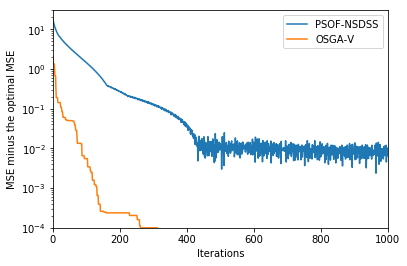

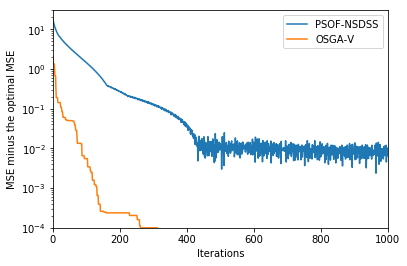

In [6]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
plt.ylim((1.0e-4, 30.0))
plt.xlim((0.0, 1000.0))
plt.yscale('log')
plt.plot(np.array(mse_nsdss_iteration, dtype=np.float32) - 3.0, label="PSOF-NSDSS")
plt.plot(np.array(osgav_css_iteration, dtype=np.float32) - 3.0, label="OSGA-V")
plt.ylabel('MSE minus the optimal MSE')
plt.xlabel('Iterations')
plt.legend()

plt.figure()
plt.ylim((1.0e-4, 30.0))
plt.xlim((0.0, 1000.0))
plt.yscale('log')
plt.plot(np.array(mse_nsdss_iteration, dtype=np.float32) - 3.0, label="PSOF-NSDSS")
plt.plot(np.array(osgav_css_iteration, dtype=np.float32) - 3.0, label="OSGA-V")
plt.ylabel('MSE minus the optimal MSE')
plt.xlabel('Iterations')
plt.legend()